<a href="https://colab.research.google.com/github/datacommonsorg/api-python/blob/master/analyzing_census_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2019 Google LLC.
SPDX-License-Identifier: Apache-2.0

**Notebook Version** - 1.0.0

# Analyzing Census Data with Data Commons

Every year, the American Community Survey (published by the US Census) reports thousands of variables about demographics, economics, housing, and more. This information, stored in Data Commons, is available to everyone for data science projects, education, and exploration. This tutorial introduces the Data Commons graph and two of its tools to help integrate its data into your data science projects: (1) the [browser](https://browser.datacommons.org/) and (2) the [Python API](https://github.com/datacommonsorg/api-python).

## What is Data Commons?

Data Commons is an open knowledge repository that combines data from public datasets using mapped common entities. It contains statements about real world objects such as

* [Santa Clara County](https://browser.datacommons.org/kg?dcid=geoId/06085) is contained in the [State of California](https://browser.datacommons.org/kg?dcid=geoId/06)
* The latitude of [Berkeley, CA](https://browser.datacommons.org/kg?dcid=geoId/0606000) is 37.8703
* [The population of Maryland](https://browser.datacommons.org/kg?dcid=dc/p/psjx4xy30nws1) was [6,003,435 in 2018](https://browser.datacommons.org/kg?dcid=dc%2Fo%2Fx1tlfg4ll9yr9).

In the graph, [*entities*](https://en.wikipedia.org/wiki/Entity) like [Santa Clara County](https://browser.datacommons.org/kg?dcid=geoId/06085) are represented by nodes. Every node has a type corresponding to what the node represents. For example, [California](https://browser.datacommons.org/kg?dcid=geoId/06) is a [State](https://schema.org/State). *Relations* between entities are represented by edges between these nodes. For example, the statement "Santa Clara County is contained in the State of California" is represented in the graph as two nodes: "Santa Clara County" and "California" with an edge labeled "[containedInPlace](https://schema.org/containedInPlace)" pointing from Santa Clara to California. Data Commons closely follows the [Schema.org data model](https://schema.org/docs/datamodel.html) and leverages Schema.org schema to provide a common set of types and properties.

## Data Commons Browser

The [Data Commons browser](https://browser.datacommons.org/) provides a way to explore the data in a human-readable format. It is the best way to explore what is in Data Commons. Searching in the browser for an entity like [Mountain View](https://browser.datacommons.org/kg?dcid=geoId/0649670), takes you to a page about the entity, including properties like [containedInPlace](https://browser.datacommons.org/kg?dcid=containedInPlace) and [timezone](https://browser.datacommons.org/kg?dcid=timezone).

An important property for all entities is the **`dcid`**. The `dcid` (Data Commons identifier) is a unique identifier assigned to each entity in the knowledge graph. With this identifier, you will be able to search for and query information on the given entity in ways that we will discuss later. The `dcid` is listed at the top of the page next to "About: " and also in the list of properties.

## Python API

The [Python API](https://github.com/datacommonsorg/api-python) provides functions for users to extract structured information from Data Commons programmatically and view them in different formats such as Python `dict`s and [Pandas](https://pandas.pydata.org/) DataFrames. DataFrames allow access to all the data processing, analytical and visualization tools provided by packages such as Pandas, NumPy, SciPy, and Matplotlib.

Let's begin by loading the Data Commons client and the standard data science libraries:


In [ ]:
# Install datacommons
!pip install git+https://github.com/datacommonsorg/api-python.git --upgrade --quiet
# Import Data Commons
import datacommons as dc

# Import other required libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

import json

## Example: Median Age vs Population by State
For this exercise, we will be comparing the median ages and population count for US states, counties, and cities. First, let's lookup the dcid for the '[United States](https://browser.datacommons.org/kg?dcid=country/USA)'.

In [ ]:
# In the browser, we saw that the dcid for United States is country/USA
usa = 'country/USA'

### Using `get_places_in` to Query Administrative Areas

The Python API defines a number of convenience functions for building Pandas dataframes with information in the datacommons graph. We will be using **`get_places_in`** which requires three arguments:

- `dcids` - A list or `pandas.Series` of dcids identifying administrative areas that we wish to get containing places for.
- `place_type` - The type of the administrative area that we wish to query for.

In Data Commons, the 'containedInPlace' property relates administrative areas to its containing administrative areas. Concretely, every US 'State' node has a directed edge to the USA 'Country' node where the name of this edge is 'containedInPlace'. The same also goes for 'County' to 'State' nodes and 'City' to 'County'.

When we provide a list of places to `get_places_in`, we get back a `dict` mapping each place to all the places contained inside it.

In [ ]:
# Create three DataFrames storing states, counties, and cities within the United States respectively.
state = pd.DataFrame({'state': dc.get_places_in([usa], 'State')[usa]})
county = pd.DataFrame({'county': dc.get_places_in([usa], 'County')[usa]})
city = pd.DataFrame({'city': dc.get_places_in([usa], 'City')[usa]})

Let's see what each table has.

In [ ]:
# Display the state data
state.head(5)

,state
0,geoId/01
1,geoId/02
2,geoId/04
3,geoId/05
4,geoId/06


In [ ]:
# Display the county data
county.head(5)

,county
0,geoId/01001
1,geoId/01003
2,geoId/01005
3,geoId/01007
4,geoId/01009


In [ ]:
# Display the city data
city.head(5)

,city
0,geoId/0100100
1,geoId/0100124
2,geoId/0100460
3,geoId/0100484
4,geoId/0100676


Unfortunately, dcids aren't very readable. Let's call **`get_property_values`** to include a column with the name for each place. This function call returns a column of names associated with each item in the calling column of dcids. Here 'name' specifies the property/edge of interest, and each of `data['state']`, `data['county']`, and `data['city']` contain dcids identifying source nodes for this relation. The `limit` specifies how many names to get. Some counties and cities have multiple spellings.

In [ ]:
# Add name columns to the three DataFrames
# If a place has multiple common names (e.g. "New York" and "New York City"), use the first one
state['state_name'] = state['state'].map(dc.get_property_values(state['state'], 'name')).str[0]
county['county_name'] = county['county'].map(dc.get_property_values(county['county'], 'name')).str[0]
city['city_name'] = city['city'].map(dc.get_property_values(city['city'], 'name')).str[0]

Let's view the result in each frame.

In [ ]:
# View the first 5 rows of the state table.
state.head(5)

,state,state_name
0,geoId/01,Alabama
1,geoId/02,Alaska
2,geoId/04,Arizona
3,geoId/05,Arkansas
4,geoId/06,California


In [ ]:
# View the first 5 rows of the county table.
county.head(5)

,county,county_name
0,geoId/01001,Autauga County
1,geoId/01003,Baldwin County
2,geoId/01005,Barbour County
3,geoId/01007,Bibb County
4,geoId/01009,Blount County


In [ ]:
# View the first 5 rows of the city table.
city.head(5)

,city,city_name
0,geoId/0100100,Abanda
1,geoId/0100124,Abbeville
2,geoId/0100460,Adamsville
3,geoId/0100484,Addison
4,geoId/0100676,Akron


Great! Now we can begin to fill our dataframe with the population and median age for each state. To do that, we'll need to understand a little bit about queryng statistical data.

### Querying Statistics from Data Commons

Data Commons has a large corpus of statistical data, which can be queried and joined with other statistics. For example, we can query the  median income of women living in Berkeley, California or the number of individuals who are insured in Maryland. 

Before we explore how to do this, we need to understand how Data Commons stores statistical data. In particular, there are two types of entities: [StatisticalVariable](https://browser.datacommons.org/kg?dcid=StatisticalVariable) and [StatVarObservation](https://browser.datacommons.org/kg?dcid=StatVarObservation).

A StatisticalVariable represents any type of statistical metric that can be measured at a place and time. Some examples include: median income, median income of females, number of high school graduates, unemployment rate, prevalence of diabetes, essentially anything you might call a metric, statistic, or measure. A StatVarObservation represents an actual measurement of a StatisticalVariable in a given place and time.

One example of a StatisticalVariable is the median age of people in San Antonio, Texas in 2014. The statistical metric, time, and place here are median age, 2014, and San Antonio respectively. A list of StatisticalVariables can be found [here](http://docs.datacommons.org/statistical_variables.html). To read more about StatisticalVariable and StatVarObservation, please see [representing_statistics.md](https://github.com/datacommonsorg/data/blob/master/docs/representing_statistics.md).

The API defines functions allowing us to fetch data over these two types. To begin with, we can use the [**`get_stats`**](http://docs.datacommons.org/api/python/stats.html) function to get the StatVarObservations of a StatisticalVariable. We are going to retrieve the total count and median age at 2017 of populations in `state['state]`, `county['county']`, and `city['city']` columns, which contain the dcids identifying the places.

**Note** - This query may take a minute!


In [ ]:
# Add a 'count' and 'med_age' columns representing the total count and
# median age of populations in state, county, and city columns.

# Define a lambda function to retrieve just the number from get_stats.
get_value = lambda row: row.get('data').get('2017')

# Get StatVarObservations for states.
state['count'] = state['state'].map(dc.get_stats(state['state'], 'Count_Person', ['2017'])).dropna().apply(get_value)
state['med_age'] = state['state'].map(dc.get_stats(state['state'], 'Median_Age_Person', ['2017'])).dropna().apply(get_value)

# Get StatVarObservations for counties.
county['count'] = county['county'].map(dc.get_stats(county['county'], 'Count_Person', ['2017'])).dropna().apply(get_value)
county['med_age'] = county['county'].map(dc.get_stats(county['county'], 'Median_Age_Person', ['2017'])).dropna().apply(get_value)

# Get StatVarObservations for cities.
city['count'] = city['city'].map(dc.get_stats(city['city'], 'Count_Person', ['2017'])).dropna().apply(get_value)
city['med_age'] = city['city'].map(dc.get_stats(city['city'], 'Median_Age_Person', ['2017'])).dropna().apply(get_value)

We view the data we've queried for.

In [ ]:
# View the first 5 rows of the state table.
state.head(5)

,state,state_name,count,med_age
0,geoId/01,Alabama,4874486,38.7
1,geoId/02,Alaska,739700,33.9
2,geoId/04,Arizona,7044008,37.2
3,geoId/05,Arkansas,3001345,37.9
4,geoId/06,California,39358497,36.1


In [ ]:
# View the first 5 rows of the county table.
county.head(5)

,county,county_name,count,med_age
0,geoId/01001,Autauga County,55390.0,37.8
1,geoId/01003,Baldwin County,212521.0,42.6
2,geoId/01005,Barbour County,25157.0,39.7
3,geoId/01007,Bibb County,22550.0,39.8
4,geoId/01009,Blount County,57787.0,40.9


In [ ]:
# View the first 5 rows of the city table.
city.head(5)

,city,city_name,count,med_age
0,geoId/0100100,Abanda,174.0,32.7
1,geoId/0100124,Abbeville,2566.0,44.9
2,geoId/0100460,Adamsville,4342.0,42.7
3,geoId/0100484,Addison,728.0,47.6
4,geoId/0100676,Akron,332.0,40.3


### Cleaning and Plotting the Data
Great! It looks like we have all the data we need. Before we finish, let's do some post-processing.



In [ ]:
# Filter for all cities that have at least one person
city = city[city['count'] >= 1]

and finally, let's visualize our results.

In [ ]:
def plot_data(title, pd_table):
  """ Generate a scatter plot comparing median age and population count. """
  plt.figure(figsize=(12, 8))
  plt.title(title)
  plt.xlabel('Median Age in Years')
  plt.ylabel('Population Count (log scale)')
  
  # Scatter plot the information
  ax = plt.gca()
  ax.set_yscale('log')
  ax.scatter(pd_table['med_age'], pd_table['count'], alpha=0.7)

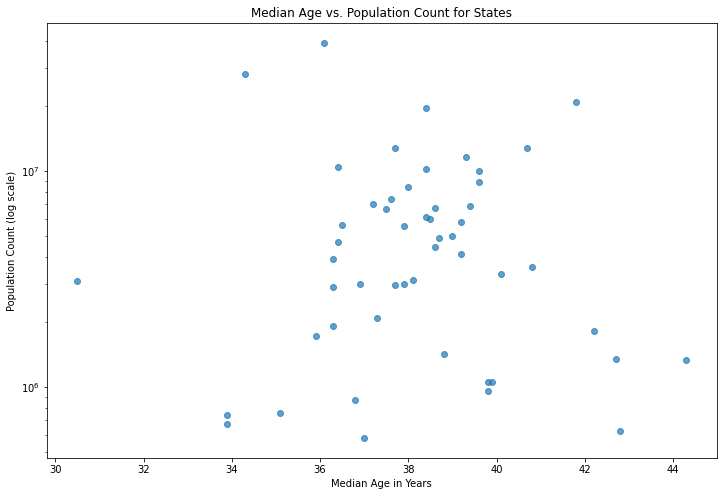

In [ ]:
# Generate the plot for state data
plot_data('Median Age vs. Population Count for States', state)

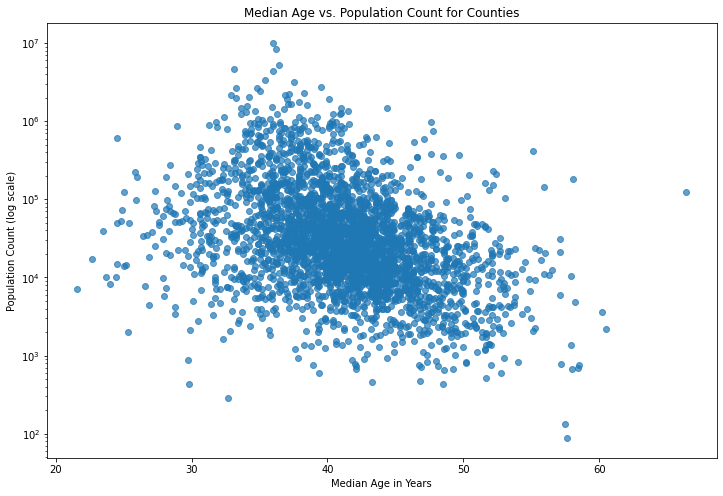

In [ ]:
# Generate the plot for county data
plot_data('Median Age vs. Population Count for Counties', county)

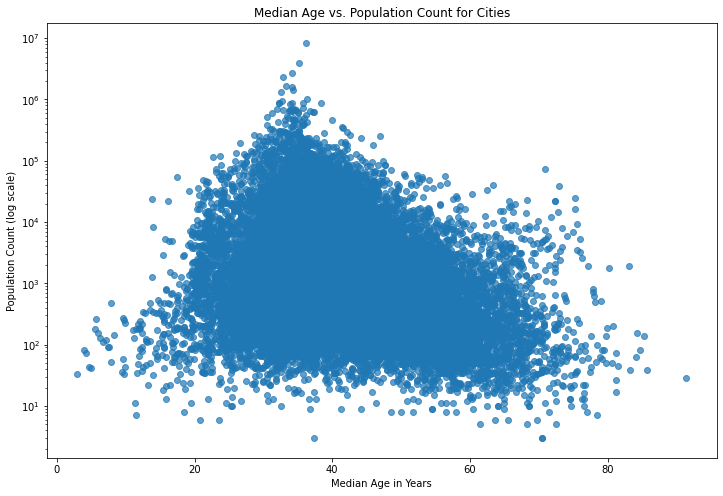

In [ ]:
# Generate the plot for city data
plot_data('Median Age vs. Population Count for Cities', city)

We can also plot each administrative area granularity on the same plot to see how they relate.

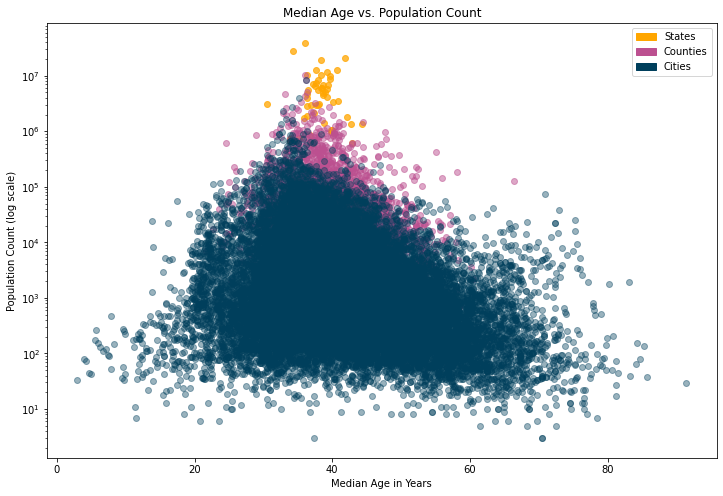

In [ ]:
def plot_all_data(state_table, county_table, city_table):
  plt.figure(figsize=(12, 8))
  plt.title('Median Age vs. Population Count')
  plt.xlabel('Median Age in Years')
  plt.ylabel('Population Count (log scale)')
  
  # Make things pretty
  state_color = "#ffa600"
  county_color = "#bc5090"
  city_color = "#003f5c"
  
  # Scatter plot the information
  ax = plt.gca()
  ax.set_yscale('log')
  ax.scatter(state_table['med_age'], state_table['count'], color=state_color, alpha=0.75)
  ax.scatter(county_table['med_age'], county_table['count'], color=county_color, alpha=0.5)
  ax.scatter(city_table['med_age'], city_table['count'], color=city_color, alpha=0.4)
  
  # Create the legend
  state_patch = mpatches.Patch(color=state_color, label='States')
  county_patch = mpatches.Patch(color=county_color, label='Counties')
  city_patch = mpatches.Patch(color=city_color, label='Cities')
  plt.legend(handles=[state_patch, county_patch, city_patch])

# Plot all the data together.
plot_all_data(state, county, city)

## What's Next

Congratulations - you've completed your first Data Commons task! Now that you have completed the tutorial, you can explore the other Data Commons notebooks to get ideas for querying and joining data from the graph.